# Total Return Test

This file contains copies of code used in the app. It's sole purpose was to test code to calculate total returns and produce graphs of the total returns for the backtests.

Any substantive work here has been incorporated into the app, and changes to the app (particularly bounds on equity and bond weights) will make this outpated.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.cluster import KMeans
#km = KMeans(n_clusters = 4)
#returns['KM labels'] = km.fit_predict(returns.set_index('Quarter'))
#returns.groupby(['SC label']).agg(['mean', 'std', 'min', 'max', 'count'])

#returns.groupby(['SC label Equity']).agg(['mean', 'std', 'min', 'max', 'count'])
#returns.groupby(['SC label', 'SC label Equity'])['Quarter'].count()

returns=pd.read_csv('/home/jpreszler/github/insight-project/data/sc-label-returns.csv')


In [2]:
def bounds_from_risk_tol(risk_tol):
    if(risk_tol==1):
        return([.20, .35, .55, .65])
    elif(risk_tol==2):
        return([.30, .45, .45, .55])
    elif(risk_tol==3):
        return([.40, .55, .35, .45])
    elif(risk_tol==4):
        return([.50, .65, .25, .35])
    elif(risk_tol==5):
        return([.60, .75, .15, .25])

def port_tsdf(portfolio, opt_portfolio, returnsDF, startQuarter, endQuarter):
    returns_small = returnsDF[(returnsDF['Quarter']>=startQuarter) & (returnsDF['Quarter']<=endQuarter)].copy()
    returns_small['Current Portfolio'] = returns_small['Equities']*portfolio['stock weight'].values[0]+returns_small['Bonds']*portfolio['bond weight'].values[0]
    returns_small['Optimal Portfolio'] = returns_small['Equities']*opt_portfolio['stock weight'].values[0]+returns_small['Bonds']*opt_portfolio['bond weight'].values[0]+returns_small['Real Estate']*opt_portfolio['real estate weight'].values[0]
    return(returns_small[['Quarter', 'Current Portfolio', 'Optimal Portfolio']])

def draw_perform(port_ts_df):
#    port_ts_df['Current Portfolio Cumulative'] = port_ts_df['Current Portfolio'].cumprod()
#    port_ts_df['Optimal Portfolio Cumulative'] = port_ts_df['Optimal Portfolio'].cumprod()

    #g = sns.lineplot(x='Quarter', y='value', hue='variable', data=pd.melt(port_ts_df, id_vars=['Quarter'], value_vars = ['Equities', 'Bonds', 'Real Estate', 'Portfolio']))
    g= sns.lineplot(x='Quarter', y='value', hue='variable', data=pd.melt(port_ts_df, id_vars=['Quarter'], value_vars=['Current Portfolio', 'Optimal Portfolio']))
    return g

def get_optimal_portfolio(risk_tolerance):
    #read datasets
    vp = pd.read_csv('/home/jpreszler/github/insight-project/wk3_app/static/vp-sharpe-all.csv')

    bds = bounds_from_risk_tol(risk_tolerance)
    vp_red = vp[((vp['stock weight']<bds[1])& (vp['stock weight']>bds[0])& (vp['bond weight']<bds[3]) & (vp['bond weight']>bds[2]))]
    opt = vp_red[vp_red['Sharpe']==vp_red['Sharpe'].max()]
    opt_df = pd.DataFrame({'name': 'Optimal', 'stock weight': opt['stock weight'].max(), 'bond weight': opt['bond weight'].max(), 'real estate weight': opt['real estate weight'].min(), 'Sharpe': opt['Sharpe'].mean()}, index=[0])

    return(opt_df)


In [3]:
ret_df = pd.read_csv('/home/jpreszler/github/insight-project/wk3_app/static/asset-returns-full-quarterly-risk-free.csv')
vp = pd.read_csv('/home/jpreszler/github/insight-project/wk3_app/static/vp-sharpe-all.csv')


In [4]:
current_portfolio = pd.DataFrame({'name':'Current', 'stock weight':.67, 'bond weight': .33, 'real estate weight':0}, index=[0])
opt_portfolio = get_optimal_portfolio(5)
    

In [6]:
port_ret5 = port_tsdf(current_portfolio, opt_portfolio, ret_df, '2014Q1', '2019Q1')
port_ret5['Current Cumulative'] = (port_ret5['Current Portfolio'].apply(lambda x: 1+x/100).cumprod()-1)*100
port_ret5['Optimal Cumulative'] = (port_ret5['Optimal Portfolio'].apply(lambda x: 1+x/100).cumprod()-1)*100
port_ret5.head()

,Quarter,Current Portfolio,Optimal Portfolio,Current Cumulative,Optimal Cumulative
144,2014Q1,1.6450,1.918568,1.645000,1.918568
145,2014Q2,3.9463,4.099931,5.656217,6.097159
146,2014Q3,0.8627,1.332490,6.567713,7.510893
147,2014Q4,3.9169,3.976528,10.741864,11.786094
148,2015Q1,1.1645,1.558088,12.031453,13.527819


In [29]:
pr_long = pd.melt(port_ret5, id_vars=['Quarter'], value_vars=['Current Portfolio', 'Optimal Portfolio'])
prl_curr = pr_long[(pr_long['variable']=='Current Portfolio')].copy()
prl_curr['cumulative'] = (prl_curr['value'].apply(lambda x: 1+x/100).cumprod()-1)*100

In [30]:
prl_curr.head()

,Quarter,variable,value,cumulative
0,2014Q1,Current Portfolio,1.6450,1.645000
1,2014Q2,Current Portfolio,3.9463,5.656217
2,2014Q3,Current Portfolio,0.8627,6.567713
3,2014Q4,Current Portfolio,3.9169,10.741864
4,2015Q1,Current Portfolio,1.1645,12.031453


In [31]:
prl_opt = pr_long[(pr_long['variable']=='Optimal Portfolio')].copy()
prl_opt['cumulative'] = (prl_opt['value'].apply(lambda x: 1+x/100).cumprod()-1)*100
prl_opt.head()

,Quarter,variable,value,cumulative
21,2014Q1,Optimal Portfolio,1.918568,1.918568
22,2014Q2,Optimal Portfolio,4.099931,6.097159
23,2014Q3,Optimal Portfolio,1.332490,7.510893
24,2014Q4,Optimal Portfolio,3.976528,11.786094
25,2015Q1,Optimal Portfolio,1.558088,13.527819


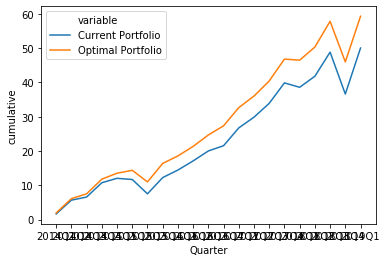

In [32]:
prl_both = pd.concat([prl_curr, prl_opt])
sns.lineplot(x='Quarter', y='cumulative', hue='variable', data=prl_both)